In [1]:
##if using Anaconda (on Anaconda terminal)
#conda install -c conda-forge xgboost 
#pip install xgboost

import sys
!{sys.executable} -m pip install xgboost

  Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)


You should consider upgrading via the 'c:\Users\greg\anaconda3\python.exe -m pip install --upgrade pip' command.


In [33]:
from sklearn.exceptions import ConvergenceWarning
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import split_X_y
from model_optimization import optimize_one_model

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = os.path.join(os.getcwd(), 'data')

## Import Labeled Data

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, 'ind4_clustering_results.csv.gz'), compression='gzip')
data

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B,cluster_label
0,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,B
1,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,B
2,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,L1
3,0,0,0,0.0,0,0,0,0,0.0,0.592736,...,0,0.0,0,0.0,0,0,0.0,0,0,B
4,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0,0,0,0.0,0,0,0,0,0.0,1.382332,...,0,0.0,0,0.0,0,0,0.0,0,0,L1
4010,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,B
4011,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,L1
4012,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0,0.0,0,0.0,0,0,0.0,0,0,L2


In [5]:
data['cluster_label'].value_counts()

L1              1931
B               1429
L2               572
Unclassified      82
Name: cluster_label, dtype: int64

In [7]:
data.describe()

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
count,4014.0,4014.0,4014.0,4014.000000,4014.0,4014.0,4014.0,4014.0,4014.000000,4014.000000,...,4014.000000,4014.0,4014.000000,4014.0,4014.000000,4014.0,4014.0,4014.000000,4014.0,4014.0
mean,0.0,0.0,0.0,0.001144,0.0,0.0,0.0,0.0,0.058993,0.124318,...,0.000572,0.0,0.007943,0.0,0.000825,0.0,0.0,0.005737,0.0,0.0
std,0.0,0.0,0.0,0.030489,0.0,0.0,0.0,0.0,0.231657,0.332214,...,0.020913,0.0,0.089159,0.0,0.030620,0.0,0.0,0.082589,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
max,0.0,0.0,0.0,1.121108,0.0,0.0,0.0,0.0,1.765982,1.760245,...,0.801262,0.0,1.446900,0.0,1.306308,0.0,0.0,1.648982,0.0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Columns: 33695 entries, RP11.34P13.3 to cluster_label
dtypes: float64(20518), int64(13176), object(1)
memory usage: 1.0+ GB


## PreProcessing

Split X, y and turn labels from string to int with values in range (0, n_classes-1).

In [4]:
X, y = split_X_y(data)
X

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,0,0,0,0.0,0,0,0,0,0.0,0.592736,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0,0,0,0.0,0,0,0,0,0.0,1.382332,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4010,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4011,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4012,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0


In [10]:
y

array([0, 0, 2, ..., 2, 1, 0])

## NestedCV to optimize each model and compare them

In [34]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, fbeta_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

NUM_TRIALS = 5

scoring = {'F1_weighted': make_scorer(f1_score, average='weighted'),
           'F1_micro': make_scorer(f1_score, average='micro'),
           'F1_macro': make_scorer(f1_score, average='macro'),
           'F2_weighted': make_scorer(fbeta_score, beta=2, zero_division=0, average='weighted'),
           'F2_micro': make_scorer(fbeta_score, beta=2, zero_division=0, average='micro'),
           'F2_macro': make_scorer(fbeta_score, beta=2, zero_division=0, average='macro'),
           'MCC': make_scorer(matthews_corrcoef),
           'Balanced_Accuracy': 'balanced_accuracy',
           }

def get_outer_scores(y_true, y_pred, results_df, idx):
    """
    Fill the dataframe which will contain all the scores for each experiment of a specific classifier

    :param y_true: True labels
    :param y_pred: Predicted labels by the best estimator of each inner cv
    :param results_df: The dataframe to fill
    :param idx: The index the results should be put
    :return: The dataframe filled at the indicated index
    """
    results_df['MCC'].loc[idx] = matthews_corrcoef(y_true, y_pred)
    results_df['F1_weighted'].loc[idx] = f1_score(y_true, y_pred, average='weighted')
    results_df['F1_micro'].loc[idx] = f1_score(y_true, y_pred, average='micro')
    results_df['F1_macro'].loc[idx] = f1_score(y_true, y_pred, average='macro')
    results_df['F2_weighted'].loc[idx] = fbeta_score(y_true, y_pred, beta=2, zero_division=0, average='weighted')
    results_df['F2_micro'].loc[idx] = fbeta_score(y_true, y_pred, beta=2, zero_division=0, average='micro')
    results_df['F2_macro'].loc[idx] = f1_score(y_true, y_pred, average='macro')
    results_df['Balanced_Accuracy'].loc[idx] = balanced_accuracy_score(y_true, y_pred)

    return results_df.copy()

def run_ncv(data_x, labels, clf_name):
    """
    Run an NCV experiment for a specific classifier whose name is required as input

    :param data_x: Dataframe of samples and features
    :param labels: numpy array of labels
    :param clf_name: a string indicating the name of the classifier
    :return: tuple
        Result scores of all experiments in a dataframe (experiment_number x score) and a list with the best parameters
        for each experiment just for inspection (DO NOT USE)
    """
    # scaler = StandardScaler()
    # scaled_data_x = scaler.fit_transform(data_x, labels)

    trial_results_df = pd.DataFrame(columns=scoring.keys(), index=[i for i in range(NUM_TRIALS)])
    best_params_list = []
    for num_trial in range(NUM_TRIALS):
        outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=num_trial)
        # count = 0
        for train_ix, test_ix in outer_cv.split(data_x, labels):
            # print(train_ix)
            x_train, x_test = data_x.loc[train_ix], data_x.loc[test_ix]
            y_train, y_test = labels[train_ix], labels[test_ix]

            #scaler = StandardScaler().fit(x_train)
            #x_train = scaler.transform(x_train)
            #x_test = scaler.transform(x_test)
            pca = PCA(n_components=10).fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)

            # count += 1
            seed = num_trial

            best_estimator, best_params = optimize_one_model(x_train, y_train, clf_name, seed)

            best_params_list.append(best_params)
            y_pred = best_estimator.predict(x_test)
            trial_results_df = get_outer_scores(y_test, y_pred, trial_results_df.copy(), num_trial)
    # print(best_params_list)

    return trial_results_df, best_params_list

def run_all_classifiers(data, targets):
    """
    START HERE
    Begin the nested cv experiment here. This function iterates over all classifier names and starts a ncv experiment for
    each one.

    :param data: A dataframe containing the features for all available samples (aka PCs)
    :param targets: The labels after turning them into numbers of range 0 to num_classes-1
    :return: Tuple
        A dictionary with keys the names of the classifiers and values the dataframes containing the scores for each,
        A dictionary containing the best params for each experiment and each classifier (Only used for inspection)
    """
    results_dict = {}
    params_dict = {}
    classifiers = {0: 'svm',
                   1: 'lr',
                   2: 'gnb',
                   3: 'rf',
                   4: 'xgb'
                   }

    for clf in classifiers.values():
        print(f'Starting NCV experiment for classifier {clf}')
        # res_df = nested_cv(clf, hyperparam_grids[key], x, y)
        res_df, best_params = run_ncv(data, targets, clf)
        results_dict[clf] = res_df
        params_dict[clf] = best_params
        # break
    return results_dict, params_dict

## Plotting functions

In [6]:
def plot_clfs_metrics(results_dict):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 9))
    my_palette = sns.color_palette("Set3")

    row, col = 0, 0
    for metric in scoring.keys():
        metric_data = pd.DataFrame()
        for clf_key, df in results_dict.items():
            metric_data[clf_key.upper()] = df[metric]
        sns.boxplot(data=metric_data, ax=axes[row][col], width=0.5, palette=my_palette)
        axes[row][col].set_title(metric)

        col += 1
        if col == 2:
            col = 0
            row += 1

    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    fig.suptitle('Classifiers metrics comparison after nested CV experiments', fontsize=22)
    plt.savefig('metrics_comparison.pdf')
    plt.show()


def plot_mccs(mcc_dict):
    fig, ax = plt.subplots(figsize=(8, 7))
    x_labels = [key.upper() for key in mcc_dict.keys()]
    y_values = mcc_dict.values()
    my_cmap = plt.get_cmap("Set3")
    plt.bar(x_labels, y_values, color=my_cmap.colors)
    plt.title('MCC mean values comparison between different classifiers', fontsize=22)
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.bar_label(ax.containers[0])
    plt.xlabel('Classifiers', fontsize=10)
    plt.savefig('mcc_compare.pdf')
    plt.show()


def plot_mean_std_errors(std_dict):
    fig, ax = plt.subplots(figsize=(8, 7))
    x_labels = [key.upper() for key in std_dict.keys()]
    y_values = std_dict.values()
    my_cmap = plt.get_cmap("Set3")
    plt.bar(x_labels, y_values, color=my_cmap.colors)
    plt.title('MCC standard error comparison between different classifiers', fontsize=22)
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.bar_label(ax.containers[0])
    plt.xlabel('Classifiers', fontsize=10)
    plt.savefig('std_e_compare.pdf')
    plt.show()


def compare_mean_mccs(results_dict):
    """
    For each classifier calculate mean MCC score and standard error
    :param results_dict: A dictionary with keys the names of the classifiers and values dataframes with the scores of
    the ncv experiments done for each one
    :return:
    Dictionary for each classifier's mean MCC score
    """
    mccs = {}
    std_errors = {}
    for key, df in results_dict.items():
        mean_mcc = df['MCC'].mean()
        std_error_mcc = df['MCC'].std(ddof=1) / np.sqrt(df['MCC'].shape[0])
        mccs[key] = mean_mcc
        std_errors[key] = std_error_mcc
    plot_mccs(mccs)
    plot_mean_std_errors(std_errors)
    return mccs

In [10]:
X.shape

(4014, 33694)

In [11]:
X.loc[[0,1,2,3]]

,RP11.34P13.3,FAM138A,OR4F5,RP11.34P13.7,RP11.34P13.8,RP11.34P13.14,RP11.34P13.9,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
0,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,0,0,0,0.0,0,0,0,0,0.0,0.000000,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,0,0,0,0.0,0,0,0,0,0.0,0.592736,...,0.0,0,0.0,0,0.0,0,0,0.0,0,0


In [35]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:36:32,037] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.4641111910994367} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:32,044] Trial 2 failed with value nan.
[W 2023-06-24 12:36:32,138] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.5471876249320794} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:32,150] Trial 7 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:36:40,237] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.22301018545510812} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:40,245] Trial 0 failed with value nan.
[W 2023-06-24 12:36:40,254] Trial 4 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 9.439482546247532} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:40,279] Trial 4 failed with value nan.
[W 2023-06-24 12:36:40,255] Trial 3 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 8.452609578633256} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:40,288] Trial 3 failed with value nan.
[W 2023-06-24 12:36:40,459] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.04239522119404724} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:40,463] Trial 7 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:36:48,281] Trial 4 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.093030782856418} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:48,289] Trial 4 failed with value nan.
[W 2023-06-24 12:36:48,405] Trial 3 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 6.452771512161226} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:48,413] Trial 3 failed with value nan.
[W 2023-06-24 12:36:48,435] Trial 5 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.5522920999435413} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:48,464] Trial 5 failed with value nan.
[W 2023-06-24 12:36:48,452] Trial 6 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 2.702539080116834} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:48,474] Trial 6 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:36:57,146] Trial 3 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.07367376499282477} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:57,155] Trial 3 failed with value nan.
[W 2023-06-24 12:36:57,177] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.32620296532964055} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:57,189] Trial 1 failed with value nan.
[W 2023-06-24 12:36:57,200] Trial 7 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.40628558601400255} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:57,211] Trial 7 failed with value nan.
[W 2023-06-24 12:36:57,227] Trial 6 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.38245004550192935} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:36:57,236] Trial 6 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:37:05,453] Trial 8 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.08630767379341141} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:05,457] Trial 8 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:37:13,178] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.07606336925180644} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:13,184] Trial 2 failed with value nan.
[W 2023-06-24 12:37:13,342] Trial 9 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 1.2001231141177782} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:13,346] Trial 9 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:37:20,808] Trial 0 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 7.505337318571772} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:20,813] Trial 0 failed with value nan.
[W 2023-06-24 12:37:20,922] Trial 6 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.03292346545134786} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:20,930] Trial 8 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.030000818203763217} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:20,939] Trial 8 failed with value nan.
[W 2023-06-24 12:37:20,935] Trial 6 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:37:29,263] Trial 1 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 0.04319597829291602} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:29,272] Trial 1 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-06-24 12:37:37,573] Trial 2 failed with parameters: {'lr_solver': 'newton-cholesky', 'lr_c': 1.3266918152531073} because of the following error: The value nan is not acceptable..
[W 2023-06-24 12:37:37,578] Trial 2 failed with value nan.


  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 9.466796648754318, 'gamma_svm': 0.02532065213037509}
Params of trial 1: {'c_svm': 8.882739562999577, 'gamma_svm': 0.07636938416515539}
Params of trial 2: {'c_svm': 6.8171630180798655, 'gamma_svm': 0.06896085844641617}
Params of trial 3: {'c_svm': 6.603015480068322, 'gamma_svm': 0.019328885102111656}
Params of trial 4: {'c_svm': 3.3419524327198493, 'gamma_svm': 0.03194089541638176}
Params of trial 5: {'c_svm': 4.225722350135788, 'gamma_svm': 0.033211701545108545}
Params of trial 6: {'c_svm': 8.756323150193928, 'gamma_svm': 0.03172390176422118}
Params of trial 7: {'c_svm': 3.658498307630858, 'gamma_svm': 0.033549207651684065}
Params of trial 8: {'c_svm': 6.308958641727966, 'gamma_svm': 0.02356279941132918}
Params of trial 9: {'c_svm': 3.0098577930784525, 'gamma_svm': 0.048234494809525276}
Params for classifier lr
Params of trial 0: {'lr_solver': 'sag', 'lr_c': 1.307116995984533}
Params of trial 1: {'lr_solver': 'newton-cg', 'lr_c': 1

## Check MCC scores to compare algorithms

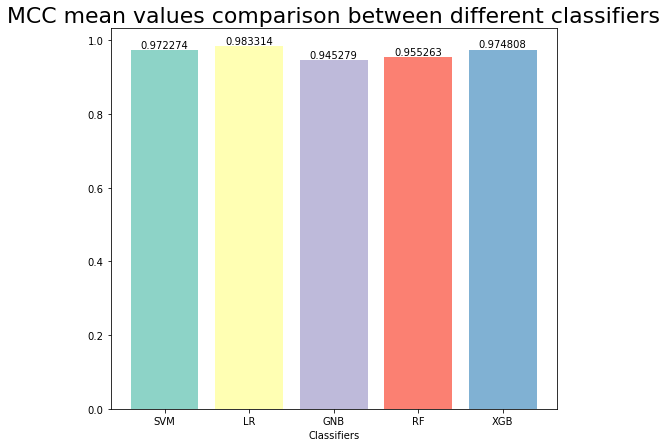

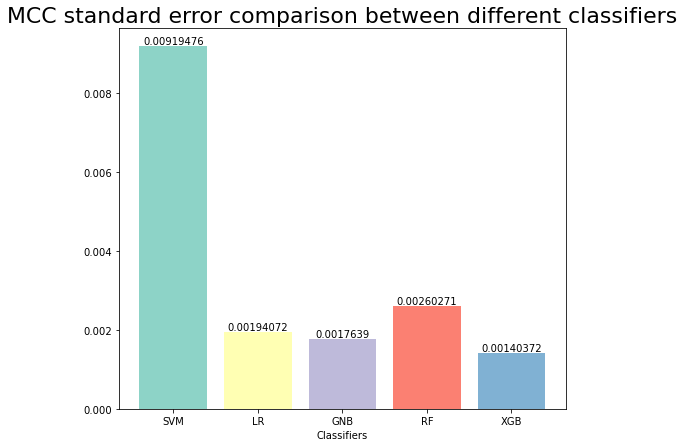

{'svm': 0.9722744196804539,
 'lr': 0.9833141029747667,
 'gnb': 0.9452791152480085,
 'rf': 0.9552627607824367,
 'xgb': 0.9748079115772683}

In [37]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

## Check boxplots of all other collected metrics for all classifiers

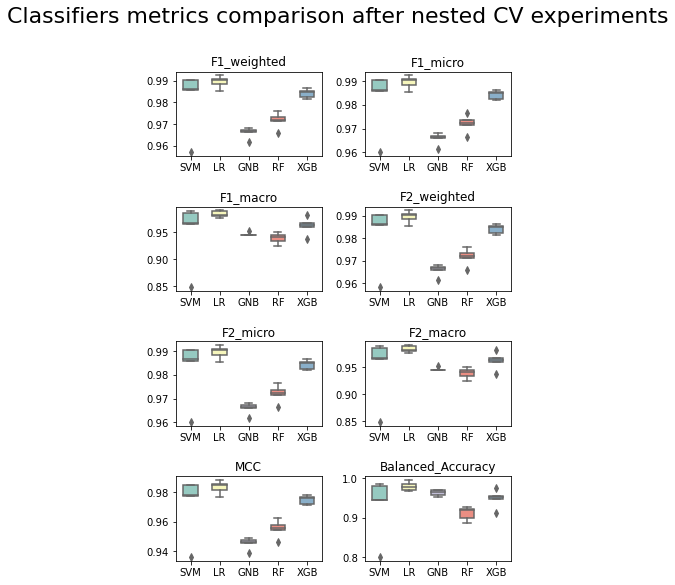

In [38]:
plot_clfs_metrics(results)